IMPORTS

In [52]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import shutil
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import probplot, shapiro, boxcox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.preprocessing import StandardScaler, PowerTransformer


FUNCTIONS

In [53]:
#CHANGE PATH TO YOUR PATH TO diagnostic_results FOLDER in the read_and_recommend function below!!! The diagnostic_results folder will be created in the current folder you are in.
def read_and_recommend(input_file_name, summary_file_name):
    """
    Reads the summary of the regression model from the input file and provides recommendations in the summary file.
    """
    # Define the directory path
    dir_path = r'C:\Users\{user_name}\Downloads\Python Projects\Regression Project\program_and_dataset\diagnostic_results'

    # Check if the directory exists
    if not os.path.exists(dir_path):
        # If not, create the directory
        os.makedirs(dir_path)

    # Define the full path for the input and summary files
    input_file_path = os.path.join(dir_path, input_file_name)
    summary_file_path = os.path.join(dir_path, summary_file_name)

    # Check if the input file exists
    if not os.path.exists(input_file_path):
        print(f"Input file {input_file_path} does not exist.")
        return

    # Check if the summary file exists
    if not os.path.exists(summary_file_path):
        # If not, create an empty file
        open(summary_file_path, 'w').close()

    # Open the input file and read the summary
    with open(input_file_path, 'r') as f:
        summary = f.read()

    # Open the summary file in append mode
    with open(summary_file_path, 'a') as f:

        # Provide recommendations based on the summary
        if "Prob (F-statistic):" in summary:
            recommendation = "Recommendation: If the F-statistic is not significant, consider applying a logarithmic transformation to your dependent variable. This can help with non-linearity and heteroscedasticity."
            print(recommendation)
            f.write(recommendation + '\n')
        if "Durbin-Watson:" in summary:
            recommendation = "Recommendation: If the Durbin-Watson statistic indicates autocorrelation, consider applying a square root transformation to your independent variables. This can help stabilize variance."
            print(recommendation)
            f.write(recommendation + '\n')
        if "Jarque-Bera (JB):" in summary:
            recommendation = "Recommendation: If the Jarque-Bera test indicates non-normality, consider applying a square transformation to your dependent variable. This can help achieve normality."
            print(recommendation)
            f.write(recommendation + '\n')
        if "Skew:" in summary:
            recommendation = "Recommendation: If the data is skewed, consider applying a cube root or Yeo-Johnson transformation. These can help reduce skewness."
            print(recommendation)
            f.write(recommendation + '\n')
        if "Cond. No." in summary:
            recommendation = "Recommendation: If the condition number is high, indicating potential multicollinearity, consider centering your variables by subtracting the mean or standardizing them. This can help mitigate multicollinearity."
            print(recommendation)
            f.write(recommendation + '\n')
        if "Omnibus:" in summary:
            recommendation = "Recommendation: If the Omnibus test indicates non-normality, consider applying a Box-Cox transformation. This can help achieve normality."
            print(recommendation)
            f.write(recommendation + '\n')

def get_stock_data(ticker, start_date, end_date, fetch_range_start=0, fetch_range_end=0):
    """
    Fetches stock data for a given ticker and date range from yfinance.
    """
    # Extend the date range for fetching data to ensure calculations go further back
    extended_start_date = pd.Timestamp(start_date) - pd.DateOffset(days=fetch_range_start)
    extended_end_date = pd.Timestamp(end_date) + pd.DateOffset(days=fetch_range_end)
    
    stock = yf.Ticker(ticker)
    data = stock.history(start=extended_start_date, end=extended_end_date)
    
    # Convert the datetime index to date
    data.index = data.index.date
    
    return data

def move_csv_files(folder='.'):
    # Create DATA directory if it doesn't exist
    if not os.path.exists('DATA'):
        os.makedirs('DATA')

    # Iterate over all files in the specified folder
    for filename in os.listdir(folder):
        # Check if the file is a .csv file
        if filename.endswith('.csv'):
            # Construct full file path
            source = os.path.join(folder, filename)
            destination = os.path.join('DATA', filename)
            # Move the file to the DATA directory
            shutil.move(source, destination)
    
def calculate_moving_average(data, period):
    """
    Calculates the moving average of a given period.
    """
    return data['Close'].rolling(window=period).mean()

def calculate_bollinger_bands(data, period, num_std):
    """
    Calculates the daily upper and lower Bollinger Bands.
    """
    rolling_mean = data['Close'].rolling(window=period).mean()
    rolling_std = data['Close'].rolling(window=period).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band

def calculate_rsi(data, period):
    """
    Calculates the daily Relative Strength Index (RSI).
    """
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_annual_dividend_yield(data, ticker):

    """
    Calculates the annual Dividend Yield based on the sum of the last 12 months of dividends and the current stock price.
    """
    stock = yf.Ticker(ticker)
    info = stock.info
    annual_dividends = info.get('dividendRate', 0)
    current_price = data['Close'].iloc[-1]
    dividend_yield = annual_dividends / current_price if current_price else 0
    return dividend_yield

def run_diagnostics_part1(data, independent_vars, dependent_var):
    """
    Runs the first set of diagnostics on the data and returns the results.
    """
    # Calculate VIF for each independent variable
    vif = pd.DataFrame()
    vif["variables"] = independent_vars
    vif["VIF"] = [variance_inflation_factor(data[independent_vars].values, i) for i in range(len(independent_vars))]

    # Boxplot for each variable
    for var in independent_vars:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=data[var])
        plt.title(f'Boxplot of {var}')
        plt.savefig(f'diagnostic_results/boxplot_{var}.png')

    # Scatterplot for each variable
    for var in independent_vars:
        plt.figure(figsize=(10, 6))
        plt.scatter(data[var], data[dependent_var])
        plt.xlabel(var)
        plt.ylabel(dependent_var)
        plt.title(f'Scatterplot of {dependent_var} vs {var}')
        plt.savefig(f'diagnostic_results/scatterplot_{var}.png')

    return vif

def run_diagnostics_part2(file_name, output_file_name):
    """
    Runs the second set of diagnostics on the regression model and saves the results to a text file.
    """
    # Load the data from the CSV file
    data= pd.read_csv(file_name)
    
    # Define the dependent variable (column 2) and independent variables (the rest of the columns)
    dependent_var = data[data.columns[1]]
    independent_vars = data[data.columns[2:]]
    noConstant_indep_vars = data[data.columns[2:-1]]
    import warnings
    from statsmodels.tools.sm_exceptions import ValueWarning
    warnings.filterwarnings(action='ignore', category=ValueWarning)

    # Run regression on the data and save summary
    model = sm.OLS(dependent_var, noConstant_indep_vars).fit()

    # Calculate residuals
    residuals = model.resid

    # Breusch-Pagan test
    bp_test = het_breuschpagan(residuals, independent_vars)

    # If the p-value of the Breusch-Pagan test is less than 0.05, we reject the null hypothesis of homoscedasticity, i.e., we have heteroscedasticity.
    if bp_test[1] < 0.05:
        print("The p-value of the Breusch-Pagan test is less than 0.05, indicating heteroscedasticity. Consider using robust standard errors.")
        model = model.get_robustcov_results()
    else:
        print("The p-value of the Breusch-Pagan test is not less than 0.05, indicating no heteroscedasticity. Non-robust standard errors can be used.")
        
    # Calculate residuals
    residuals = model.resid


    # Plot the residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, model.resid)
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted Values')
    

    # Durbin-Watson test
    dw = durbin_watson(residuals)

    # Shapiro-Wilk test
    shapiro_test = shapiro(residuals)

    # Prepare independent variables for the tests
    exog = independent_vars
    exog3 = noConstant_indep_vars

    # Calculate the rank of the exog matrix
    rank_exog = np.linalg.matrix_rank(exog) 

    # Calculate model.df_model + 1
    df_model_plus_one = model.df_model+1
    
    # Compare the two values
   
    # Breusch-Pagan test
    bp_test = het_breuschpagan(residuals, exog)


    # Q-Q plot of the residuals
    plt.figure(figsize=(10, 6))
    probplot(residuals, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    plt.savefig('diagnostic_results/qq_plot.png')

    # Save the summary to a text file
    with open(os.path.join('diagnostic_results', 'diagnostics_summary_part_2.txt'), 'w') as f:
        f.write(model.summary().as_text())

    # Return the diagnostics
    return dw, shapiro_test, bp_test

def plot_regressions(model_train, model_test):
    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot the train data
    plt.subplot(1, 2, 1)
    plt.scatter(model_train.fittedvalues, model_train.model.endog, label='Data')
    plt.plot(model_train.fittedvalues, model_train.fittedvalues, color='red', label='Fit')
    plt.xlabel('Fitted Values')
    plt.ylabel('Actual Values')
    plt.title('Train Data')
    plt.legend()

    # Plot the test data
    plt.subplot(1, 2, 2)
    plt.scatter(model_test.fittedvalues, model_test.model.endog, label='Data')
    plt.plot(model_test.fittedvalues, model_test.fittedvalues, color='red', label='Fit')
    plt.xlabel('Fitted Values')
    plt.ylabel('Actual Values')
    plt.title('Test Data')
    plt.legend()

    # Adjust the layout
    plt.tight_layout()
# Define transformation functions
def log_transform(data, column):
    data[column] = np.log(data[column])
def sqrt_transform(data, column):
    data[column] = np.sqrt(data[column])
def cube_root_transform(data, column):
    data[column] = np.cbrt(data[column])
def polynomial_transform(data, column, degree):
    data[column] = data[column] ** degree
def standardize(data, column):
    scaler = StandardScaler()
    data[column] = scaler.fit_transform(data[[column]])
def center(data, column):
    mean = data[column].mean()
    data[column] = data[column] - mean
def box_cox_transform(data, column):
    data[column], _ = stats.boxcox(data[column])
def yeo_johnson_transform(data, column):
    pt = PowerTransformer(method='yeo-johnson')
    data[column] = pt.fit_transform(data[[column]])
# Define the main function
def transform_and_run_regression(train_file, test_file, transformations, error_type):
    # Load the data
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)

    # Apply transformations
    for column, transformation in transformations:
        if transformation == 'log':
            log_transform(train_data, column)
            log_transform(test_data, column)
        elif transformation == 'sqrt':
            sqrt_transform(train_data, column)
            sqrt_transform(test_data, column)
        elif transformation == 'cube_root':
            cube_root_transform(train_data, column)
            cube_root_transform(test_data, column)
        elif transformation == 'polynomial':
            polynomial_transform(train_data, column, 2)  # Change the degree as needed
            polynomial_transform(test_data, column, 2)
        elif transformation == 'standardize':
            standardize(train_data, column)
            standardize(test_data, column)
        elif transformation == 'center':
            center(train_data, column)
            center(test_data, column)
        elif transformation == 'box_cox':
            box_cox_transform(train_data, column)
            box_cox_transform(test_data, column)
        elif transformation == 'yeo_johnson':
            yeo_johnson_transform(train_data, column)
            yeo_johnson_transform(test_data, column)

    # Define the dependent variable (column 2) and independent variables (the rest of the columns)
    dependent_var_train = train_data[train_data.columns[1]]
    independent_vars_train = train_data[train_data.columns[2:]]

    dependent_var_test = test_data[test_data.columns[1]]
    independent_vars_test = test_data[test_data.columns[2:]]

    # Run regression on the train data and save summary
    model_train = sm.OLS(dependent_var_train, independent_vars_train).fit(cov_type=error_type)

    # Run regression on the test data and save summary
    model_test = sm.OLS(dependent_var_test, independent_vars_test).fit(cov_type=error_type)

    # Create a new directory for the final results
    if not os.path.exists('Final_Results'):
        os.makedirs('Final_Results')

    # Save the summaries to a text file in the new directory
    with open(os.path.join('Final_Results', 'train_summary.txt'), 'w') as f:
        f.write(model_train.summary().as_text())
    with open(os.path.join('Final_Results', 'test_summary.txt'), 'w') as f:
        f.write(model_test.summary().as_text())

    # Plot both regressions with best fit line and save them both to the Final Results folder
    plot_regressions(model_train, model_test)

    # Save the plots to the new directory
    plt.savefig(os.path.join('Final_Results', 'final_regression_plots.png'))
    
    move_csv_files()

    print("The summaries have been saved to the 'Final_Results' directory.")


PARAMETERS

In [54]:
ticker = 'NVDA'  # Or any other ticker you want to analyze
start_date = '2020-01-01'
end_date = '2022-01-01'

CREATE MENU OF VARIABLES TO CHOOSE FROM

In [55]:
# Fetch stock data with an extended buffer to ensure enough data points for calculations
data = get_stock_data(ticker, start_date, end_date, fetch_range_start=365 + 20, fetch_range_end=0)

# Calculate indicators
data['MA20'] = calculate_moving_average(data, 20)
data['RSI14'] = calculate_rsi(data, 14)
upper_band, lower_band = calculate_bollinger_bands(data, 20, 2)
data['Bollinger_Upper'] = upper_band
data['Bollinger_Lower'] = lower_band
data['Annual_Dividend_Yield'] = calculate_annual_dividend_yield(data, ticker)

# Reset index and rename the column to 'Date'
data.reset_index(inplace=True)
data.rename(columns={'index': 'Date'}, inplace=True)

# Convert start_date and end_date to datetime.date
start_date = pd.to_datetime(start_date).date()
end_date = pd.to_datetime(end_date).date()

# Filter data within the specified date range
data_within_range = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

# Save all data to a CSV file
data_within_range.to_csv('calculated.vars.csv', index=False)

# Load all data from the CSV file
all_data = pd.read_csv('calculated.vars.csv')

# Convert 'Date' column to datetime.date
all_data['Date'] = pd.to_datetime(all_data['Date']).dt.date

# Filter data within the specified date range
data_within_range = all_data[(all_data['Date'] >= start_date) & (all_data['Date'] <= end_date)]

# Save all data to a CSV file
data_within_range.to_csv('calculated.vars.csv', index=False)

# Define the file names
calculated_vars_file = 'calculated.vars.csv'
economic_data_file = 'economic.data.csv'

# Load the data and convert the 'Date' column to datetime
calculated_vars = pd.read_csv(calculated_vars_file)
calculated_vars['Date'] = pd.to_datetime(calculated_vars['Date']).dt.date

economic_data = pd.read_csv(economic_data_file)
economic_data['Date'] = pd.to_datetime(economic_data['Date']).dt.date

# Merge the dataframes on the 'Date' column
merged_data = pd.merge(calculated_vars, economic_data, on='Date', how='left')

# Fill the missing values in each column by using the nearest entry
merged_data.bfill(inplace=True)
merged_data.ffill(inplace=True)

# Define the output file name
output_file = 'regression.variable.menu.csv'

# Save the dataframe to a new csv file
merged_data.to_csv(output_file, index=False)

# Load the 'regression.variable.menu.csv' file
menu_data = pd.read_csv('regression.variable.menu.csv')
menu_data['Date'] = pd.to_datetime(menu_data['Date']).dt.date


VARIABLE CHOOSING AND DATA SPLITTING

In [56]:
# Specify the column names you want to select for regression
column_names_menu_selection = ['Date', 'Close', 'Volume', 'Unemployment Rate', 'rf_3 Yr']  # replace with your actual column names

#Keep the Date Selected; the second choice will be used as the dependent variable

# Select specified columns
noConstant_columns_selected = menu_data[column_names_menu_selection]

# Save the noConstant selected columns to a new CSV file
noConstant_columns_selected.to_csv('noConstant_columns_selected.csv', index=False)

# Load the 'noConstant_columns_selected.csv' file
noConstant_columns_selected = pd.read_csv('noConstant_columns_selected.csv')

#Add a constant column for linear regression sm.add_constant
yesConstant_columns_selected = sm.add_constant(noConstant_columns_selected,prepend=False)




#Split the data into training and testing sets
train_data, test_data = train_test_split(yesConstant_columns_selected, test_size=0.2, shuffle=False)

#Save the training and testing sets to separate CSV files
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)



DIAGNOSTIC TEST 1

['Volume', 'Unemployment Rate', 'rf_3 Yr', 'const']
           variables        VIF
0             Volume   1.035471
1  Unemployment Rate   1.384984
2            rf_3 Yr   1.352670
3              const  16.271989

No variables to remove. All VIF values are below the threshold.


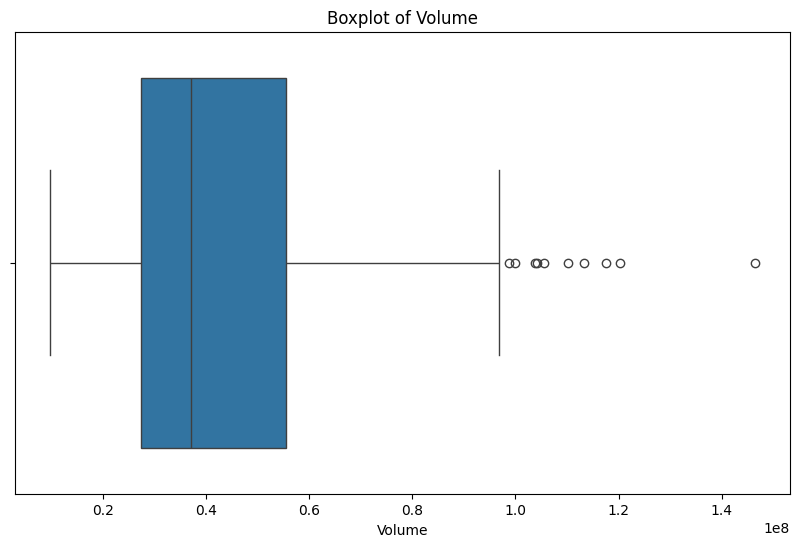

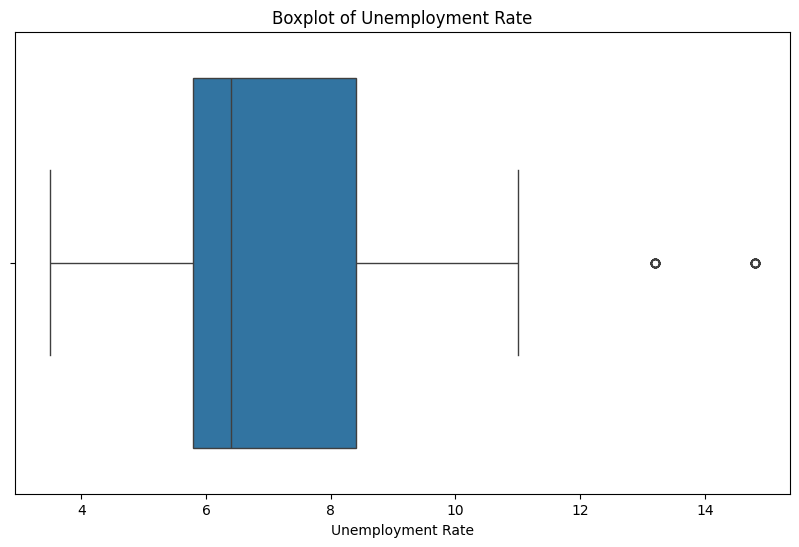

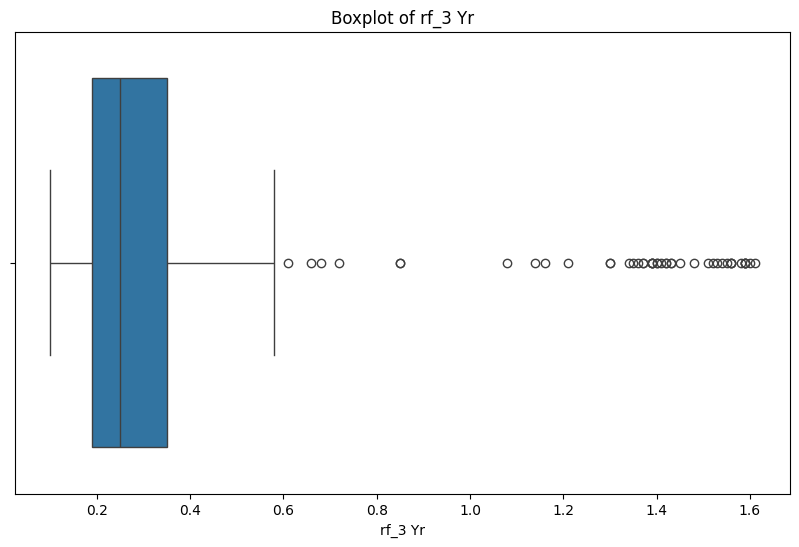

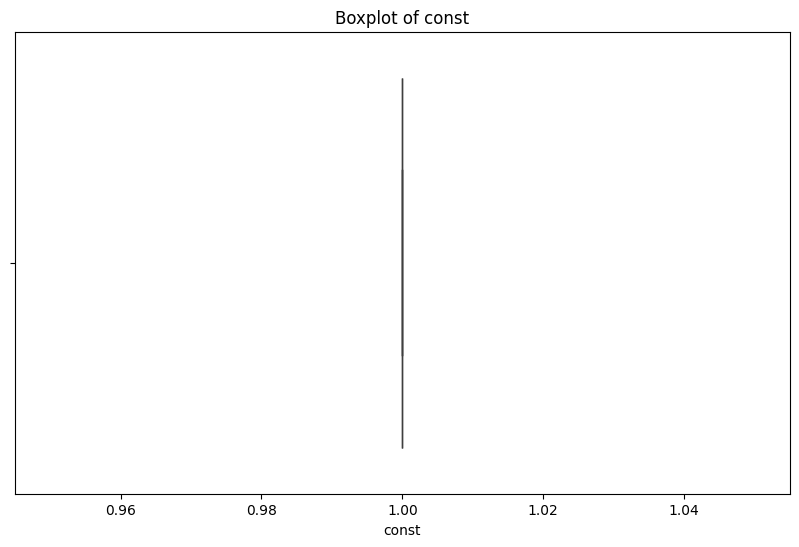

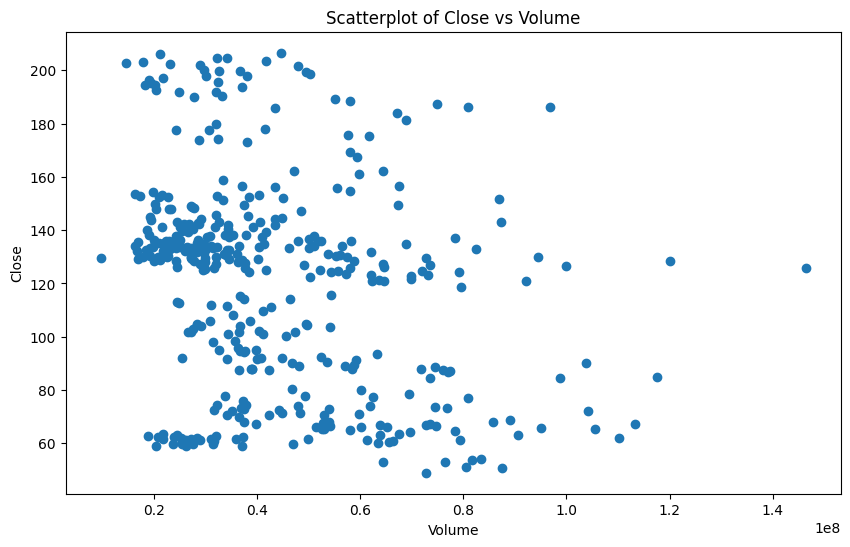

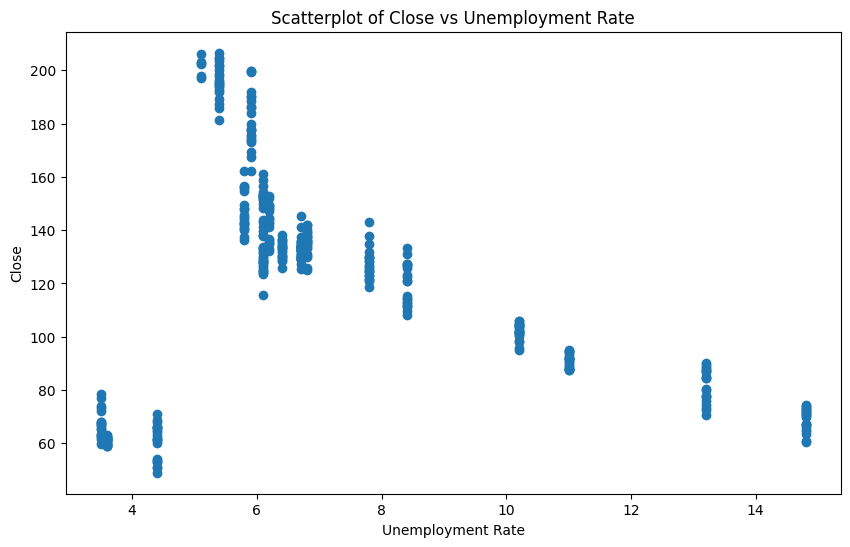

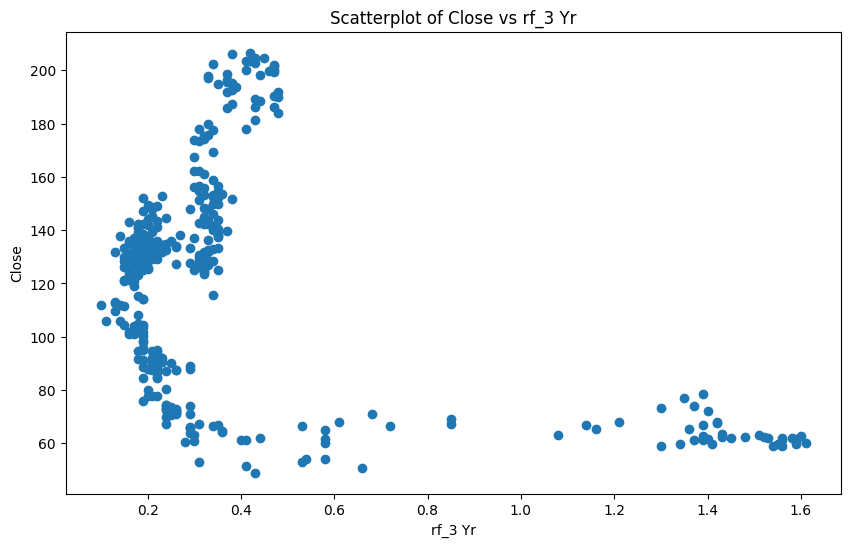

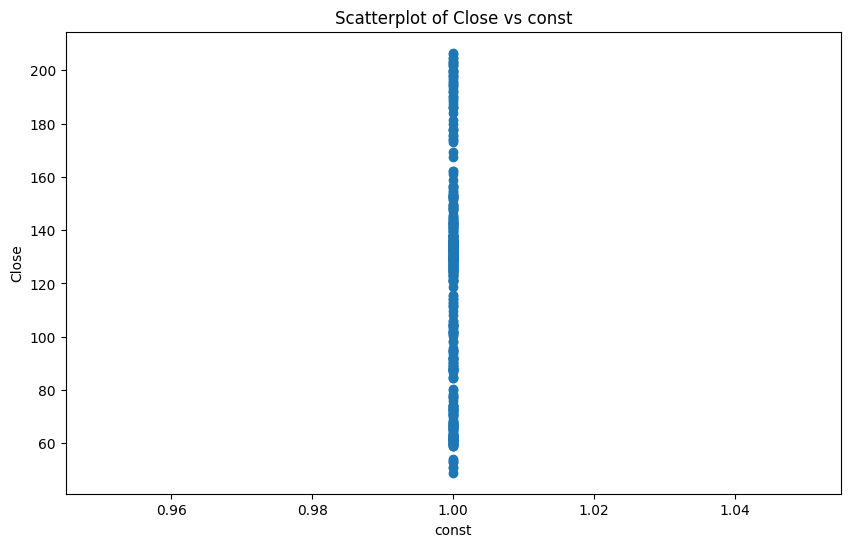

In [57]:
# Load the training data
train_data = pd.read_csv('train_data.csv')

# Get the column names
column_names_diag1 = train_data.columns.tolist()


# Specify your dependent variable and independent variables
dependent_var = column_names_diag1[1]  # set to col 1 b/c col 0 is date and when selecting columns(variables) for regression,the first non date column will be the dependent variable
independent_vars = column_names_diag1[2:]  # assuming the rest of the columns are the independent variables
print (independent_vars)
# Run the first set of diagnostics

# Create a directory for diagnostics if it doesn't exist
if not os.path.exists('diagnostic_results'):
    os.makedirs('diagnostic_results')

# Run the first set of diagnostics
vif = run_diagnostics_part1(train_data, independent_vars, dependent_var)

# Print VIF and suggest variables to remove
print(vif)
high_vif_vars = vif[vif['VIF'] > 30]['variables']
if not high_vif_vars.empty:
    print("\nConsider removing the following variables due to high multicollinearity:")
    print(high_vif_vars)
else:
    print("\nNo variables to remove. All VIF values are below the threshold.")


# Save the summary to a text file
with open(os.path.join('diagnostic_results', 'diagnostics_summary_part1.txt'), 'w') as f:
    f.write("Variance Inflation Factor (VIF):\n")
    f.write(vif.to_string())
    if not high_vif_vars.empty:
        f.write("\n\nConsider removing the following variables due to high multicollinearity:\n")
        f.write(high_vif_vars.to_string())
        f.write("\n\nIf these variables are important for your analysis, consider using techniques that are less sensitive to multicollinearity, such as Ridge Regression or Principal Component Analysis (PCA).")
    else:
        f.write("\n\nNo variables to remove. All VIF values are below the threshold.")


DIAGNOSTIC TEST 2

The p-value of the Breusch-Pagan test is less than 0.05, indicating heteroscedasticity. Consider using robust standard errors.


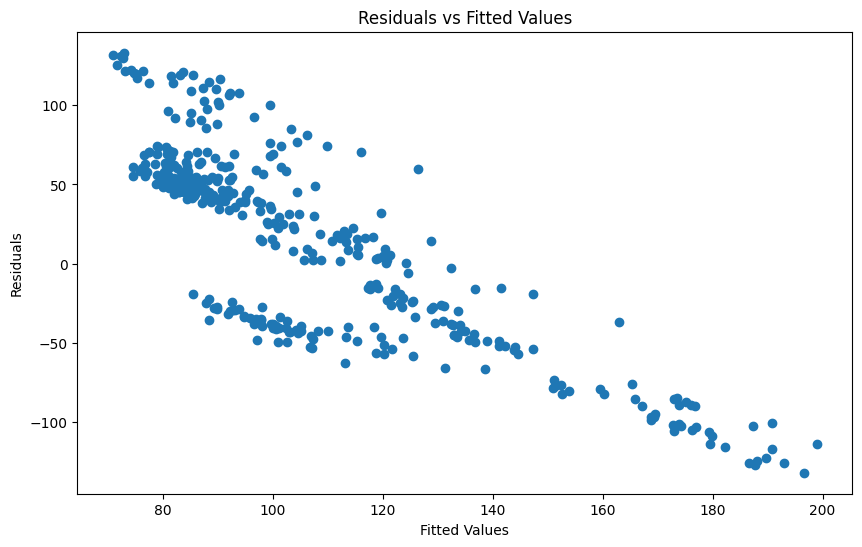

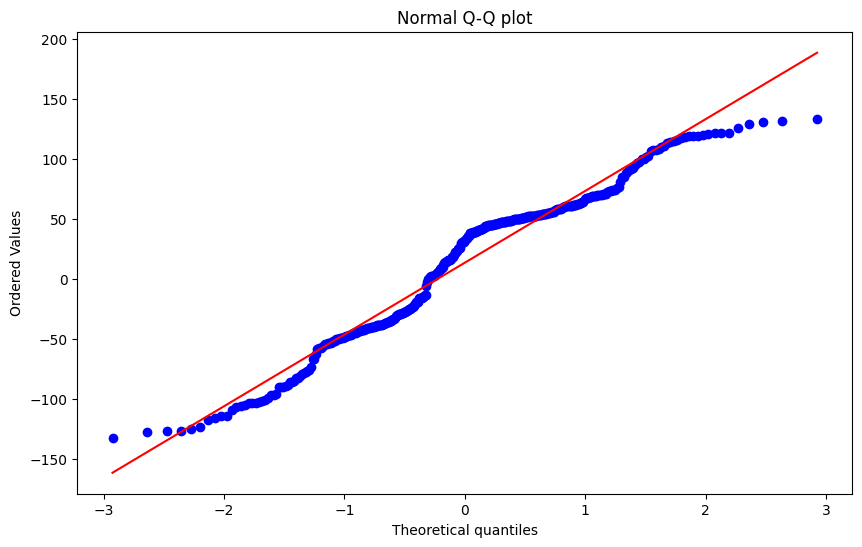

In [58]:
dw, shapiro_test, bp_test = run_diagnostics_part2('train_data.csv', 'diagnostics_summary_part_2.txt')


RECIEVE SUGGESTIONS

In [59]:

read_and_recommend('diagnostics_summary_part_2.txt', 'diag2_recommendations.txt')


Recommendation: If the F-statistic is not significant, consider applying a logarithmic transformation to your dependent variable. This can help with non-linearity and heteroscedasticity.
Recommendation: If the Durbin-Watson statistic indicates autocorrelation, consider applying a square root transformation to your independent variables. This can help stabilize variance.
Recommendation: If the Jarque-Bera test indicates non-normality, consider applying a square transformation to your dependent variable. This can help achieve normality.
Recommendation: If the data is skewed, consider applying a cube root or Yeo-Johnson transformation. These can help reduce skewness.
Recommendation: If the condition number is high, indicating potential multicollinearity, consider centering your variables by subtracting the mean or standardizing them. This can help mitigate multicollinearity.
Recommendation: If the Omnibus test indicates non-normality, consider applying a Box-Cox transformation. This can h

APPLY TRANSFORMATIONS AND RUN REGRESSION ON TEST ADN TRAIN DATA

The summaries have been saved to the 'Final_Results' directory.


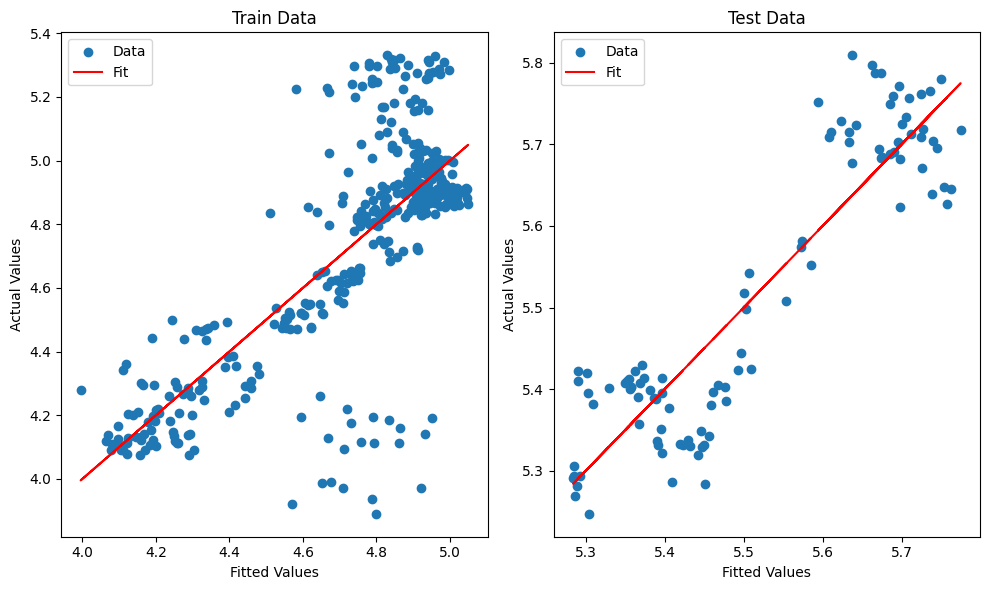

In [60]:
# Specify the transformations to apply
# Replace 'column1', 'column2', etc. with your actual column names
# Replace 'log', 'sqrt', etc. with the actual transformations you want to apply
transformations = [('Close', 'log')]

# Specify the type of HC standard errors to use
error_type = 'HC3'

# Specify the train and test data files
train_file = 'train_data.csv'
test_file = 'test_data.csv'

# Call the transform_and_run_regression function
transform_and_run_regression(train_file, test_file, transformations, error_type)
